<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.5
## Feature Selection

### Data

**Predict the onset of diabetes based on diagnostic measures.**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

[Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database/download)

In [57]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

from sklearn.svm import SVC
# from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.feature_selection import RFE

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

%matplotlib inline

#### 1. Load Data

In [58]:
diabetes_csv = 'diabetes.csv'
#breast_cancer_csv = 'breast-cancer-wisconsin-data.csv'
data = pd.read_csv(diabetes_csv)

#### 2. Perform EDA

Perform EDA. Check Null Values. Impute if necessary.

In [59]:
# Head
data.head().T

,0,1,2,3,4
Pregnancies,6.000,1.000,8.000,1.000,0.000
Glucose,148.000,85.000,183.000,89.000,137.000
BloodPressure,72.000,66.000,64.000,66.000,40.000
SkinThickness,35.000,29.000,0.000,23.000,35.000
Insulin,0.000,0.000,0.000,94.000,168.000
BMI,33.600,26.600,23.300,28.100,43.100
DiabetesPedigreeFunction,0.627,0.351,0.672,0.167,2.288
Age,50.000,31.000,32.000,21.000,33.000
Outcome,1.000,0.000,1.000,0.000,1.000


In [60]:
data.shape

(768, 9)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [62]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

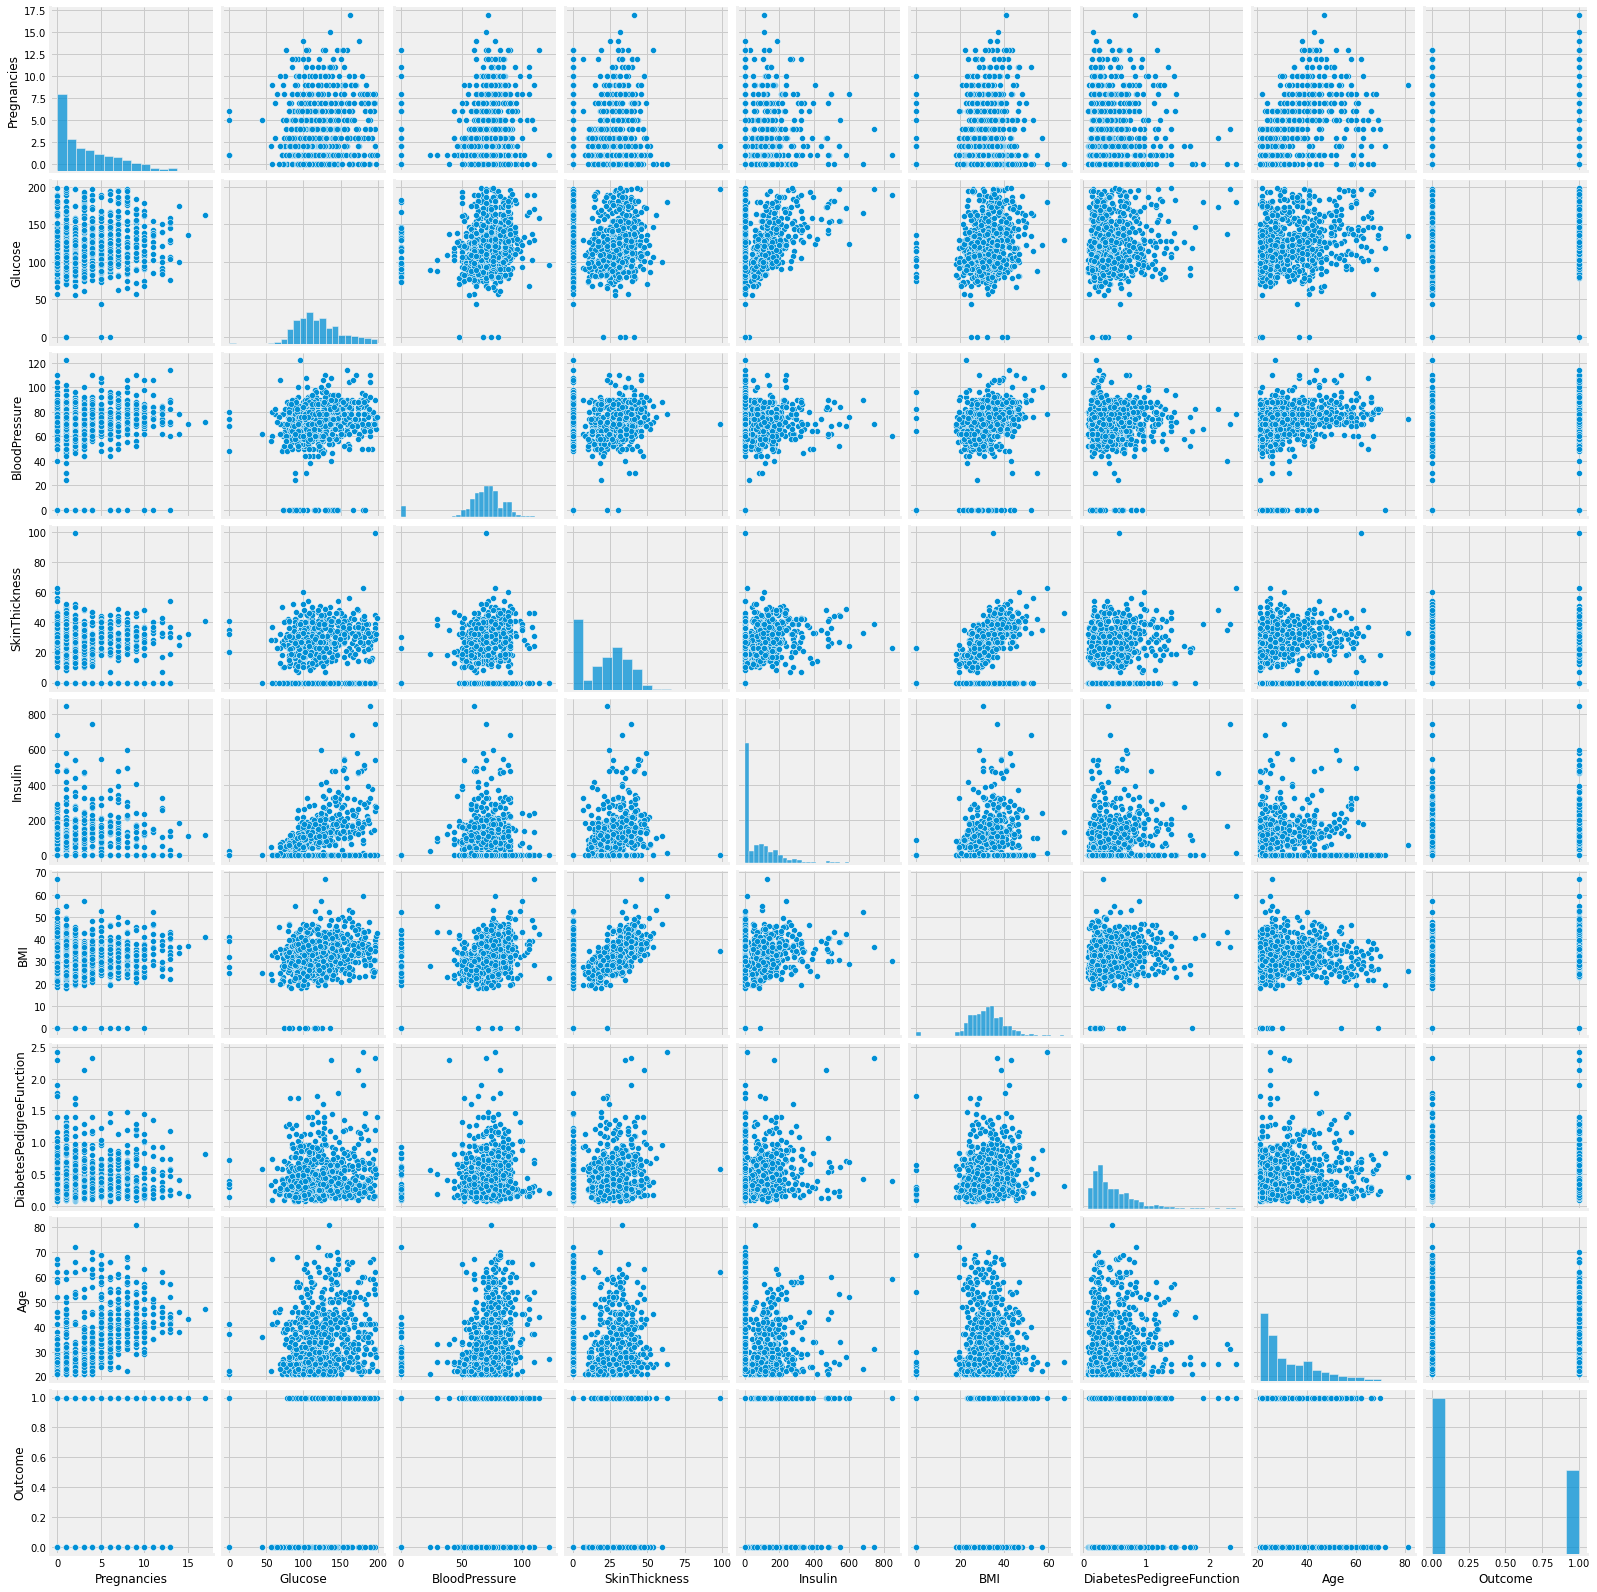

In [63]:
sns.pairplot(data)

In [64]:
print(data)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

In [65]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### 3. Set Target

- Set `Outcome` as target.
- Set Features 

In [66]:
# Target Variable
y = data['Outcome']
#Select all predictors except target variable
X = data.drop('Outcome', axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

#### 4. Select Feature

The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.

##### 4.1 Univariate Selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method:

- SelectKBest removes all but the  highest scoring features
- Use sklearn.feature_selection.chi2 as score function
    > Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.


More Reads:
[Univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)

- Create an instance of SelectKBest
    - Use sklearn.feature_selection.chi2 as score_func
    - Use k of your choice
- Fit X, y 
- Find top 4 features
- Transform features to a DataFrame

In [67]:
# Create an instance of SelectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 
selector = SelectKBest(score_func=chi2, k='all')

In [68]:
# Fit 
selector = selector.fit(X, y)
selector

SelectKBest(k='all', score_func=<function chi2 at 0x0000024ED3E35160>)

In [69]:
X_new = selector.transform(X)
X_new

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

In [70]:
# Print Score 
scores = selector.scores_
scores

array([ 111.51969064, 1411.88704064,   17.60537322,   53.10803984,
       2175.56527292,  127.66934333,    5.39268155,  181.30368904])

In [71]:
# Find Top 4 Features
selector = SelectKBest(score_func=chi2, k=4).fit(X, y)
X_new = selector.transform(X)
X_new

array([[148. ,   0. ,  33.6,  50. ],
       [ 85. ,   0. ,  26.6,  31. ],
       [183. ,   0. ,  23.3,  32. ],
       ...,
       [121. , 112. ,  26.2,  30. ],
       [126. ,   0. ,  30.1,  47. ],
       [ 93. ,   0. ,  30.4,  23. ]])

In [89]:
# Transform X to Features
features = selector.get_support(1) #the most important features


In [90]:
# Transform features to a dataframe
X_new = X[X.columns[features]] 
X_new

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction
0,6,148,33.6,0.627
1,1,85,26.6,0.351
2,8,183,23.3,0.672
3,1,89,28.1,0.167
4,0,137,43.1,2.288
...,...,...,...,...
763,10,101,32.9,0.171
764,2,122,36.8,0.340
765,5,121,26.2,0.245
766,1,126,30.1,0.349


In [99]:
score = selector.score(X, y)
score

0.76953125

##### 4.2 Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

More Reads:
[Recursive feature elimination](https://scikit-learn.org/stable/modules/feature_selection.html)

- Use RFE to extract feature
    - use LogisticRegression as estimator
    - Number of n_features_to_select as of your choice
- Fit X, y to RFE
- Find Selected Features

In [116]:
# ANSWER
import sklearn
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=4)
rfe = rfe.fit(X, y)



C:\Users\65911\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [117]:
rfe.support_

array([ True,  True, False, False, False,  True,  True, False])

In [118]:
rfe.ranking_

array([1, 1, 3, 4, 5, 1, 1, 2])

In [119]:
# Print Score 
score = rfe.score(X, y)
score


0.76953125

In [114]:
# Find Features

X.columns[rfe.support_]

Index(['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction'], dtype='object')



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



